<a href="https://colab.research.google.com/github/lazy-wolf/python-class-notes/blob/main/TensorFlow_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Assignment 2**

```
# Authoured by: Wasim Dawood Shaik
# UNB ID: 3744476
# Date: 23-10-2023
```

**Delivarable_1 : Create your own separate python notebooks in Colab for each of the three sources.**




**Creating separate python notebooks in Colab for using pre-trained models and dataset from Tensorflow**

**Import Libraries**

In [30]:
from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,ConfusionMatrixDisplay,classification_report

**Importing Dataset from TensorFlow Datasets**




In [31]:
(training_set, validation_set), dataset_info = tfds.load(
    'imagewang/160px',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

**Dataset Info**

[imagewang datset link](https://www.tensorflow.org/datasets/catalog/imagewang#imagewang160px)

*https://www.tensorflow.org/datasets/catalog/imagewang#imagewang160px*

In [32]:
dataset_info

tfds.core.DatasetInfo(
    name='imagewang',
    full_name='imagewang/160px/2.0.0',
    description="""
    Imagewang contains Imagenette and Imagewoof combined Image网 (pronounced
    "Imagewang"; 网 means "net" in Chinese) contains Imagenette and Imagewoof
    combined, but with some twists that make it into a tricky semi-supervised
    unbalanced classification problem:
    
    *   The validation set is the same as Imagewoof (i.e. 30% of Imagewoof images);
        there are no Imagenette images in the validation set (they're all in the
        training set)
    *   Only 10% of Imagewoof images are in the training set!
    *   The remaining are in the unsup ("unsupervised") directory, and you can not
        use their labels in training!
    *   It's even hard to type and hard to say!
    
    The dataset comes in three variants:
    
    *   Full size
    *   320 px
    *   160 px
    
    This dataset consists of the Imagenette dataset {size} variant.
    """,
    config_description

**Data Preprocessing and Data Analysis**

In [36]:
training_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [37]:
validation_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [38]:
dataset_info.features['label']

ClassLabel(shape=(), dtype=int64, num_classes=20)

In [39]:
dataset_info.features['label'].num_classes

20

In [40]:
num_classes = dataset_info.features['label'].num_classes

In [41]:
dataset_info.features['label'].names

['n03394916',
 'n03417042',
 'n02089973',
 'n02086240',
 'n02105641',
 'n02087394',
 'n02099601',
 'n02115641',
 'n03445777',
 'n02102040',
 'n03425413',
 'n03888257',
 'n03028079',
 'n03000684',
 'n01440764',
 'n02093754',
 'n02111889',
 'n02096294',
 'n02088364',
 'n02979186']

In [42]:
len(training_set)

10268

In [43]:
len(validation_set)

4401

In [44]:
training_dict={}
for i in training_set:
  if dataset_info.features['label'].names[i[1].numpy()] not in training_dict:
    training_dict[dataset_info.features['label'].names[i[1].numpy()]]=1
  else:
    training_dict[dataset_info.features['label'].names[i[1].numpy()]]+=1


In [45]:
training_df=pd.DataFrame(training_dict.items(),columns=['Labels','Count'])

In [46]:
training_df['Count'].sum()

10268

In [47]:
num_training_examples = training_df['Count'].sum()

<Axes: xlabel='Labels'>

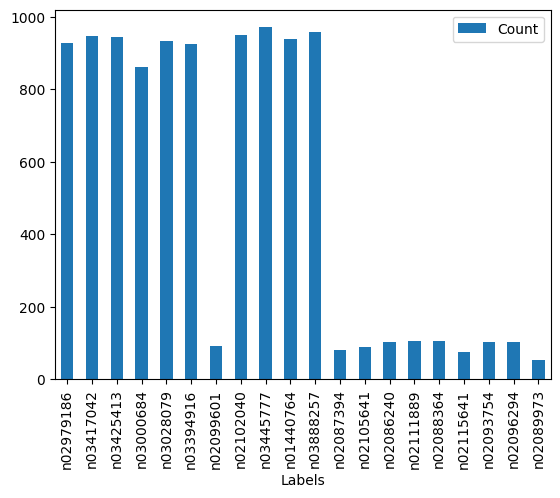

In [48]:
training_df.plot.bar(x="Labels", y="Count", rot=90)


In [49]:
validation_dict={}
for i in validation_set:
  if dataset_info.features['label'].names[i[1].numpy()] not in validation_dict:
    validation_dict[dataset_info.features['label'].names[i[1].numpy()]]=1
  else:
    validation_dict[dataset_info.features['label'].names[i[1].numpy()]]+=1

In [50]:
validation_df=pd.DataFrame(validation_dict.items(),columns=['Labels','Count'])

In [51]:
validation_df['Count'].sum()

4401

In [52]:
num_validation_examples = validation_df['Count'].sum()

<Axes: xlabel='Labels'>

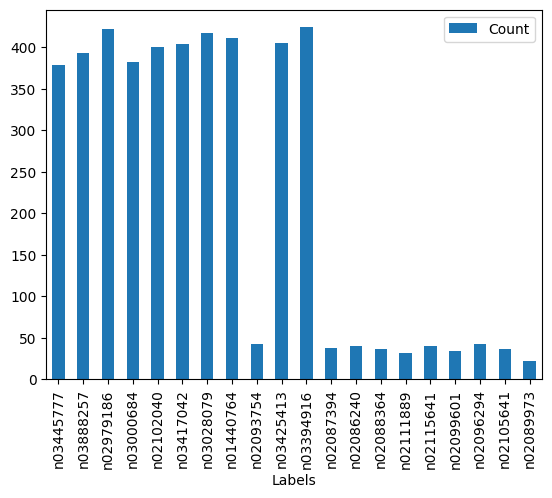

In [53]:
validation_df.plot.bar(x="Labels", y="Count", rot=90)

In [54]:
IMAGE_RES = 128
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label
BATCH_SIZE = 32
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)
print(train_batches)
print(validation_batches)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


**Create a Model**

[mobilenet-v2 link](https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-classification/versions/2)

*https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-classification/versions/2*

In [55]:
URL = "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-classification/versions/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [56]:
model = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              1692489   
                                                                 
 dense_1 (Dense)             (None, 20)                20040     
                                                                 
Total params: 1712529 (6.53 MB)
Trainable params: 20040 (78.28 KB)
Non-trainable params: 1692489 (6.46 MB)
_________________________________________________________________


**Compile and Train the Model**

In [57]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # different loss function for multiclass classifcation
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"]
             )

In [58]:
learning_rate_reduction=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",patience=2,factor=0.5, min_lr=0.00001,verbose =1)
Early_Stopping= tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5, restore_best_weights=True)

In [59]:
history_1= model.fit(train_batches, epochs=20, validation_data= validation_batches,callbacks=[Early_Stopping,learning_rate_reduction], verbose=1)

Epoch 1/20
321/321 [==============================] - 117s 177ms/step - loss: 0.6519 - accuracy: 0.8196 - val_loss: 0.3782 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 2/20
321/321 [==============================] - 61s 190ms/step - loss: 0.3016 - accuracy: 0.9068 - val_loss: 0.3845 - val_accuracy: 0.8955 - lr: 0.0010
Epoch 3/20
321/321 [==============================] - ETA: 0s - loss: 0.2312 - accuracy: 0.9276
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
321/321 [==============================] - 60s 188ms/step - loss: 0.2312 - accuracy: 0.9276 - val_loss: 0.3934 - val_accuracy: 0.8959 - lr: 0.0010
Epoch 4/20
321/321 [==============================] - 61s 191ms/step - loss: 0.1554 - accuracy: 0.9529 - val_loss: 0.3687 - val_accuracy: 0.9021 - lr: 5.0000e-04
Epoch 5/20
321/321 [==============================] - 55s 173ms/step - loss: 0.1322 - accuracy: 0.9602 - val_loss: 0.3770 - val_accuracy: 0.9016 - lr: 5.0000e-04
Epoch 6/20
321/321 [====================

**Evaluate the Model**

In [60]:
loss, accuracy= model.evaluate(validation_batches)
print(f"loss is: {loss}")
print(f"accuacy is: {accuracy}")

138/138 [==============================] - 41s 295ms/step - loss: 0.3687 - accuracy: 0.9021
loss is: 0.3687160611152649
accuacy is: 0.9020677208900452


In [61]:
history_mobilenet_v2= pd.DataFrame(history_1.history)
history_mobilenet_v2.head()

,loss,accuracy,val_loss,val_accuracy,lr
0,0.651859,0.819634,0.378232,0.890025,0.0010
1,0.301552,0.906798,0.384460,0.895478,0.0010
2,0.231205,0.927639,0.393379,0.895933,0.0010
3,0.155374,0.952863,0.368716,0.902068,0.0005
4,0.132205,0.960168,0.377033,0.901613,0.0005


**Plot Training History**

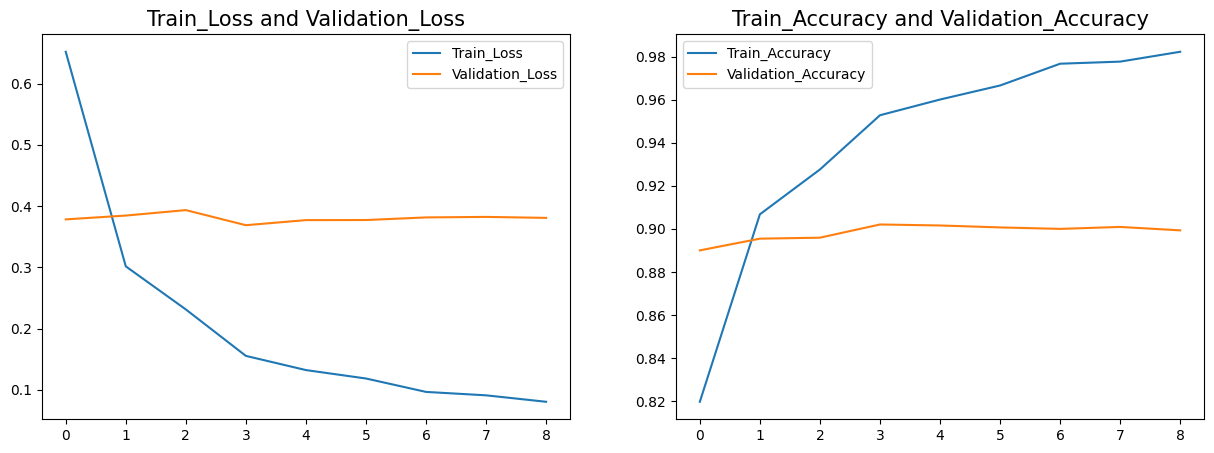

In [62]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history_mobilenet_v2['loss'],label='Train_Loss')
plt.plot(history_mobilenet_v2['val_loss'],label='Validation_Loss')
plt.title('Train_Loss and Validation_Loss',fontsize=15)
plt.legend()


plt.subplot(1,2,2)
plt.plot(history_mobilenet_v2['accuracy'],label='Train_Accuracy')
plt.plot(history_mobilenet_v2['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy and Validation_Accuracy',fontsize=15)
plt.legend()
plt.show()

**Model Accuracy**

In [63]:
x_test=[]
y_test=[]
y_pred=[]

for images, labels in validation_batches:
    x_test.extend(images.numpy())
    y_test.extend(labels.numpy())


predictions=model.predict(np.array(x_test))
for i in predictions:
    y_pred.append(np.argmax(i))

138/138 [==============================] - 19s 128ms/step


**Accuracy Score of Model on Test Dataset**

In [75]:
accuracy_score(y_test, y_pred)*100

90.20677118836629

In [65]:
class_names = np.array(dataset_info.features['label'].names)
print(class_names)

['n03394916' 'n03417042' 'n02089973' 'n02086240' 'n02105641' 'n02087394'
 'n02099601' 'n02115641' 'n03445777' 'n02102040' 'n03425413' 'n03888257'
 'n03028079' 'n03000684' 'n01440764' 'n02093754' 'n02111889' 'n02096294'
 'n02088364' 'n02979186']


**Delivarable_2 : Show a few examples of the predicted output**

**Showing Examples of Predicted Output**

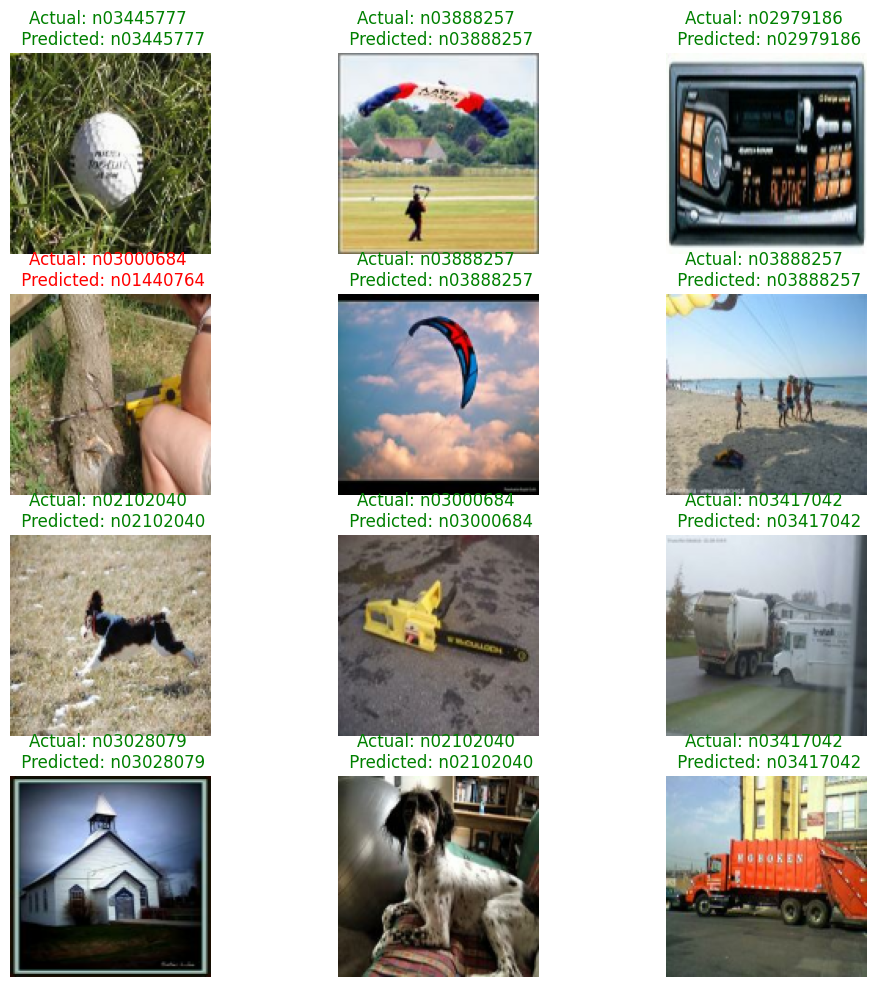

In [67]:
plt.figure(figsize=(12, 12))

for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(x_test[i])
    actual_label = class_names[y_test[i]]
    predicted_label = class_names[y_pred[i]]

    # Check if the actual and predicted labels are the same
    if actual_label == predicted_label:
        label_color = 'green'
    else:
        label_color = 'red'

    plt.title(f'Actual: {actual_label} \n Predicted: {predicted_label}', color=label_color)
    plt.axis("off")

plt.show()

**F-1, Precision, Recall Scores - Macro**

In [68]:
f1_score_value = f1_score(y_pred, y_test, average="macro")
precision_score_value = precision_score(y_pred, y_test, average="macro")
recall_score_value = recall_score(y_pred, y_test, average="macro")

# Print the Results
print(f"F1-Score:{f1_score_value}")
print(f"Precision:{precision_score_value}")
print(f"Recall:{recall_score_value}")

F1-Score:0.8018576616926529
Precision:0.7970283998148449
Recall:0.8153644592577116


In [69]:
y_test_labels=list(map(lambda e: class_names[e], y_test))

In [70]:
y_test_labels[:5]

['n03445777', 'n03888257', 'n02979186', 'n03000684', 'n03888257']

In [71]:
y_pred_labels=list(map(lambda e: class_names[e], y_pred))

In [72]:
y_pred_labels[:5]

['n03445777', 'n03888257', 'n02979186', 'n01440764', 'n03888257']

**Classification Report**

In [73]:
print("Classification_Report")
print("-----------------------")
print(classification_report(y_test_labels,y_pred_labels))

Classification_Report
-----------------------
              precision    recall  f1-score   support

   n01440764       0.97      0.96      0.96       411
   n02086240       0.80      0.80      0.80        40
   n02087394       0.67      0.63      0.65        38
   n02088364       0.50      0.47      0.49        36
   n02089973       0.64      0.41      0.50        22
   n02093754       0.77      0.71      0.74        42
   n02096294       0.75      0.88      0.81        43
   n02099601       0.69      0.79      0.74        34
   n02102040       0.90      0.93      0.92       400
   n02105641       0.86      0.51      0.64        37
   n02111889       0.74      0.81      0.78        32
   n02115641       0.70      0.70      0.70        40
   n02979186       0.92      0.93      0.92       422
   n03000684       0.84      0.84      0.84       382
   n03028079       0.92      0.95      0.94       417
   n03394916       0.90      0.94      0.92       424
   n03417042       0.90      0.94  

**Delivarable_3 : Display the results of the prediction results using a confusion matrix**

**Displaying Prediction Results using Confusion Matrix**

Confusion_Matrix
----------------------


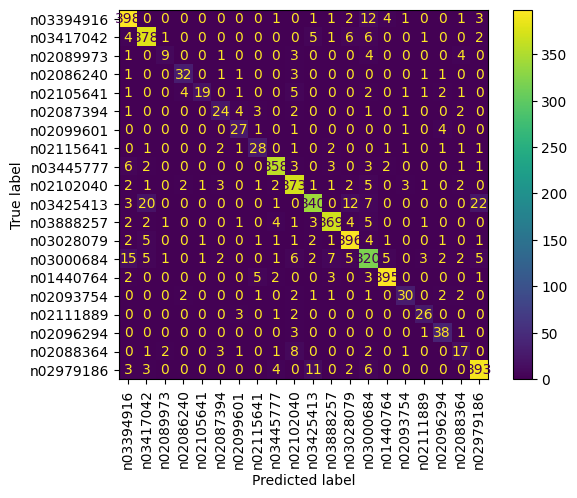

In [74]:
print("Confusion_Matrix")
print("----------------------")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=class_names, xticks_rotation="vertical")
plt.show()